<a href="https://colab.research.google.com/github/hitanshu5/Crop-Yield-Prediction-System/blob/main/Crop_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/final_df.csv')
df.head()

,District,Crop,Year,Season,Area,Temperature,Rainfall,Yield
0,1,2,1997,2,40800.0,23.998425,112.450,0.455882
1,1,4,1997,2,900.0,23.998425,112.450,1.222222
2,1,4,1997,3,598400.0,21.448471,9.375,0.362634
3,1,5,1997,2,4400.0,23.998425,112.450,1.068182
4,1,5,1997,3,6200.0,21.448471,9.375,1.467742


In [ ]:
rows_to_drop = df[(df['Yield'] < 0) | (df['Yield'] > 100)].index

df = df.drop(index=rows_to_drop)
df = df.reset_index(drop=True)

In [ ]:
df.shape

(13904, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13904 entries, 0 to 13903
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     13904 non-null  int64  
 1   Crop         13904 non-null  int64  
 2   Year         13904 non-null  int64  
 3   Season       13904 non-null  int64  
 4   Area         13904 non-null  float64
 5   Temperature  13904 non-null  float64
 6   Rainfall     13904 non-null  float64
 7   Yield        13904 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 869.1 KB


## We use multiple different models to compare and evaluate the best performing one (by comparing the RMSE scores)

In [ ]:
X = df.drop(columns=['Rainfall', 'Temperature','Yield','Area','Crop'])
y = df['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 3), (2781, 3), (11123,), (2781,))

In [ ]:
X_train

,District,Year,Season
13434,7,2023,2
5556,26,2007,2
2252,24,2001,2
12522,26,2021,2
2578,11,2002,2
...,...,...,...
5191,4,2007,3
13418,7,2023,2
5390,16,2007,4
860,8,1999,2


# RandomForest Regressor

In [ ]:
rf_r = RandomForestRegressor(n_estimators=100, random_state=42)
rf_r.fit(X_train, y_train)

y_pred_rf = rf_r.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 25.30103244330996
Random Forest R² Score: 0.9548741341988871


# GradientBoost Regressor

In [ ]:
gb_r = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_r.fit(X_train, y_train)

y_pred_gb = gb_r.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting R² Score: {r2_gb}")

Gradient Boosting RMSE: 44.31718458065892
Gradient Boosting R² Score: 0.8615498644657082


# XGBoost Regressor

In [ ]:
xgb_r = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_r.fit(X_train, y_train)

y_pred_xgb = xgb_r.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R² Score: {r2_xgb}")

XGBoost RMSE: 31.245214020353302
XGBoost R² Score: 0.9311797781814973


# LSTM

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model_r = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model_r.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

lstm_model_r.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model_r.predict(X_test_reshaped).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM R² Score: {r2_lstm}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 27196.1465
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11138.4443
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5326.7729
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4738.8486
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4631.2764
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4535.5576
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4392.0430
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4455.8174
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4553.9380
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4159.4194
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4283.2236
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4459.8604
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4207.9556
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4307.5361
Epoch 15/50
3

# SVR

In [ ]:
svm_regressor_r = SVR(kernel='rbf')
svm_regressor_r.fit(X_train, y_train)

y_pred_svr = svm_regressor_r.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVM Regressor RMSE: {rmse_svr:.4f}")
print(f"SVM Regressor R² Score: {r2_svr:.4f}")

SVM Regressor RMSE: 119.8277
SVM Regressor R² Score: -0.0122


### Displaying the results for the various models

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LSTM', 'SVR'],
    'RMSE': [rmse_rf, rmse_gb, rmse_xgb, rmse_lstm, rmse_svr],
    'R² Score': [r2_rf, r2_gb, r2_xgb, r2_lstm, r2_svr]
})

print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"Best Model based on RMSE: {best_model['Model']} with RMSE {best_model['RMSE']:.4f}")

best_model_r2 = results.loc[results['R² Score'].idxmax()]
print(f"Best Model based on R² Score: {best_model_r2['Model']} with R² Score {best_model_r2['R² Score']:.4f}")

               Model        RMSE  R² Score
0      Random Forest   25.301032  0.954874
1  Gradient Boosting   44.317185  0.861550
2            XGBoost   31.245214  0.931180
3               LSTM   64.553077  0.706247
4                SVR  119.827722 -0.012194
Best Model based on RMSE: Random Forest with RMSE 25.3010
Best Model based on R² Score: Random Forest with R² Score 0.9549


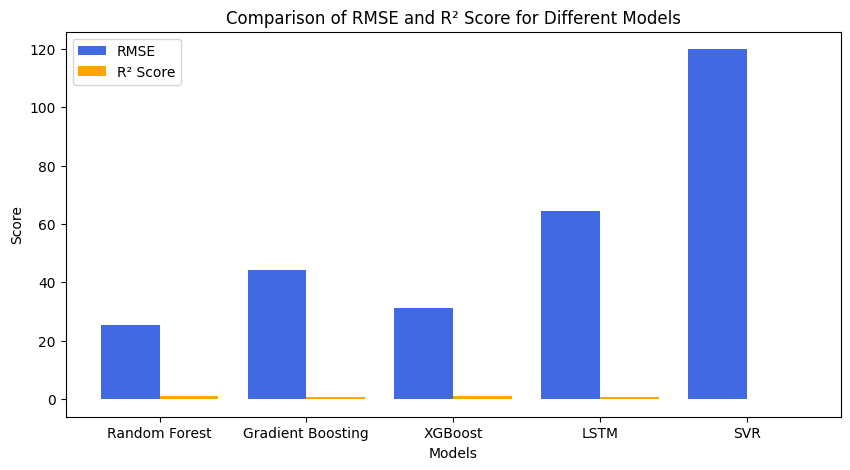

In [ ]:
plt.figure(figsize=(10, 5))

bar_width = 0.4
models = results['Model']
x = np.arange(len(models))

plt.bar(x - bar_width/2, results['RMSE'], width=bar_width, label='RMSE', color='royalblue')
plt.bar(x + bar_width/2, results['R² Score'], width=bar_width, label='R² Score', color='orange')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of RMSE and R² Score for Different Models")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

### Predicing rainfall

In [ ]:
district = int(input("Enter District (as integer): "))
year = int(input("Enter Year: "))
season = int(input("Enter Season (as integer): "))

user_input = np.array([[district, year, season]])

predicted_rainfall = rf_r.predict(user_input)[0]

print(f"Predicted Rainfall: {predicted_rainfall:.2f} mm")

Enter District (as integer): 1
Enter Year: 2030
Enter Season (as integer): 2
Predicted Rainfall: 149.39 mm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# For Temperature

## We use multiple different models to compare and evaluate the best performing one (by comparing the RMSE scores)

In [ ]:
X = df.drop(columns=['Temperature','Yield','Area','Crop'])
y = df['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 4), (2781, 4), (11123,), (2781,))

## Random Forest

In [ ]:
rf_t = RandomForestRegressor(n_estimators=100, random_state=42)
rf_t.fit(X_train, y_train)

y_pred_rf = rf_t.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 0.30386371816125185
Random Forest R² Score: 0.9884599367227371


## Gradient Boosting Regressor

In [ ]:
gb_t = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_t.fit(X_train, y_train)

y_pred_gb = gb_t.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting R² Score: {r2_gb}")

Gradient Boosting RMSE: 0.7846039790389119
Gradient Boosting R² Score: 0.9230601195129412


## XGBoost

In [ ]:
xgb_t = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_t.fit(X_train, y_train)

y_pred_xgb = xgb_t.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R² Score: {r2_xgb}")

XGBoost RMSE: 0.4028382414124856
XGBoost R² Score: 0.9797179486656383


## LSTM

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model_t = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model_t.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

lstm_model_t.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model_t.predict(X_test_reshaped).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM R² Score: {r2_lstm}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 390.6750
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.9488
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2678
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4782
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5618
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9288
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6041
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4199
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3446
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2274
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.0894
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.1192
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9753
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9636
Epoch 15/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.929

## SVR

In [ ]:
svm_regressor_t = SVR(kernel='rbf')
svm_regressor_t.fit(X_train, y_train)

y_pred_svr = svm_regressor_t.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVM Regressor RMSE: {rmse_svr:.4f}")
print(f"SVM Regressor R² Score: {r2_svr:.4f}")

SVM Regressor RMSE: 3.0258
SVM Regressor R² Score: -0.1443


### Displaying the results for the various models

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LSTM', 'SVR'],
    'RMSE': [rmse_rf, rmse_gb, rmse_xgb, rmse_lstm, rmse_svr],
    'R² Score': [r2_rf, r2_gb, r2_xgb, r2_lstm, r2_svr]
})

print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"Best Model based on RMSE: {best_model['Model']} with RMSE {best_model['RMSE']:.4f}")

best_model_r2 = results.loc[results['R² Score'].idxmax()]
print(f"Best Model based on R² Score: {best_model_r2['Model']} with R² Score {best_model_r2['R² Score']:.4f}")

               Model      RMSE  R² Score
0      Random Forest  0.303864  0.988460
1  Gradient Boosting  0.784604  0.923060
2            XGBoost  0.402838  0.979718
3               LSTM  1.291828  0.791426
4                SVR  3.025814 -0.144287
Best Model based on RMSE: Random Forest with RMSE 0.3039
Best Model based on R² Score: Random Forest with R² Score 0.9885


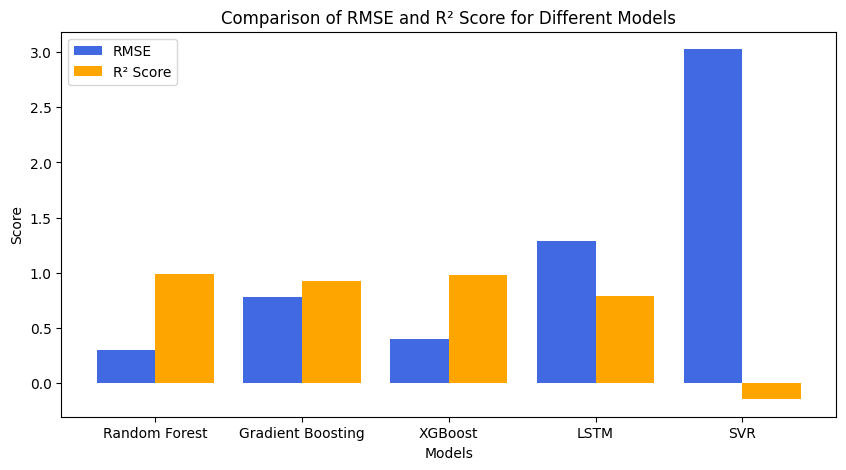

In [ ]:
plt.figure(figsize=(10, 5))

bar_width = 0.4
models = results['Model']
x = np.arange(len(models))

plt.bar(x - bar_width/2, results['RMSE'], width=bar_width, label='RMSE', color='royalblue')
plt.bar(x + bar_width/2, results['R² Score'], width=bar_width, label='R² Score', color='orange')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of RMSE and R² Score for Different Models")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

# CNN-LSTM (for TSA Approach)

In [ ]:
df_tsa = df.copy()

if not pd.api.types.is_datetime64_any_dtype(df_tsa['Year']):
    df_tsa['Year'] = pd.to_datetime(df_tsa['Year'].astype(str), format='%Y').dt.year
else:
    df_tsa['Year'] = df_tsa['Year'].dt.year

tsa_features = ['District', 'Area', 'Year', 'Season', 'Temperature', 'Rainfall', 'Crop']
X_tsa = df_tsa[tsa_features].values
y_tsa = df_tsa['Yield'].values.reshape(-1, 1)

scaler_tsa = StandardScaler()
X_tsa_scaled = scaler_tsa.fit_transform(X_tsa)
scaler_y = StandardScaler()
y_tsa_scaled = scaler_y.fit_transform(y_tsa)

time_steps = 3
n_features = X_tsa_scaled.shape[1]

X_tsa_seq = np.array([X_tsa_scaled[i-time_steps:i] for i in range(time_steps, len(X_tsa_scaled))])
y_tsa_seq = y_tsa_scaled[time_steps:]

X_train, X_test, y_train, y_test = train_test_split(X_tsa_seq, y_tsa_seq, test_size=0.25, random_state=42)

def build_optimized_cnn_lstm_model(time_steps, n_features):
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(time_steps, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2, activation='tanh')))
    model.add(Dropout(0.3))

    model.add(LSTM(64, activation='tanh', return_sequences=False, recurrent_dropout=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='mse')

    return model

model_tsa = build_optimized_cnn_lstm_model(time_steps, n_features)
model_tsa.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model_tsa.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[early_stopping], verbose=1)

y_pred_scaled = model_tsa.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)

print("\n🔹 Model Evaluation Metrics:")
print(f"✔️ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✔️ Mean Squared Error (MSE): {mse:.4f}")
print(f"✔️ Root Mean Squared Error (RMSE): {rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3, 128)              │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3, 256)              │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,305 (1.20 MB)

 Trainable params: 313,921 (1.20 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - loss: 0.9078 - val_loss: 0.7921
Epoch 2/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.8326 - val_loss: 0.7154
Epoch 3/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.7868 - val_loss: 0.7231
Epoch 4/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.7612 - val_loss: 0.7008
Epoch 5/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.7666 - val_loss: 0.6751
Epoch 6/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.7045 - val_loss: 0.6736
Epoch 7/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - loss: 0.7057 - val_loss: 0.6682
Epoch 8/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.6840 - val_loss: 0.6627
Epoch 9/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.6860 - val_loss: 0.6577
Epoch 10/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.6721 - val_loss: 0.6547
Epoch 11/150
326/326 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.6755 - val_loss: 0.6404
Epoch 12/150
326/32

# LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Preparation ---
# Assume your DataFrame 'df' is already loaded.
# Define feature columns and the target column.
features = ['District', 'Crop', 'Year', 'Season', 'Area', 'Temperature', 'Rainfall']
target = 'Yield'

# Extract features and target from df
X = df[features].values
y = df[target].values

# Scale the features (recommended for training LSTMs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape to 3D array: (samples, time_steps, features)
# Here, each sample is treated as a sequence with a single time step.
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Custom Regression Accuracy Function ---
def regression_accuracy(y_true, y_pred, threshold=0.1):
    """
    Computes a custom accuracy metric for regression.
    A prediction is considered 'accurate' if its relative error is below the threshold.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    epsilon = 1e-8  # to avoid division by zero
    relative_error = np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon)
    accuracy = np.mean(relative_error < threshold)
    return accuracy

# --- Complex LSTM Model Definition ---
def build_complex_lstm_model(time_steps, n_features):
    model = Sequential()

    # First LSTM layer (bidirectional) with return_sequences enabled for stacking
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', recurrent_dropout=0.2),
                            input_shape=(time_steps, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second LSTM layer (stacked)
    model.add(LSTM(128, return_sequences=True, activation='tanh', recurrent_dropout=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third LSTM layer (bidirectional) to capture deeper temporal features
    model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh', recurrent_dropout=0.2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Dense layers for regression output
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Exponential learning rate decay
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Determine the input shape from the training data
time_steps = X_train.shape[1]   # should be 1 in this case
n_features = X_train.shape[2]   # number of features (7 for this dataset)

# Build and display the model
model = build_complex_lstm_model(time_steps, n_features)
model.summary()

# --- Early Stopping Callback ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Model Training ---
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1,
                    callbacks=[early_stop], verbose=1)

# --- Predictions and Metrics Calculation ---
# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate custom regression accuracy for training and testing sets
train_accuracy = regression_accuracy(y_train, y_train_pred, threshold=0.1)
test_accuracy = regression_accuracy(y_test, y_test_pred, threshold=0.1)

print("Training RMSE:", train_rmse)
print("Training Accuracy (relative error < 10%):", train_accuracy)
print("Testing RMSE:", test_rmse)
print("Testing Accuracy (relative error < 10%):", test_accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │         139,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 447,617 (1.71 MB)

 Trainable params: 446,593 (1.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.4864 - val_loss: 0.2421
Epoch 2/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.2922 - val_loss: 0.2479
Epoch 3/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 0.2637 - val_loss: 0.2124
Epoch 4/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.2573 - val_loss: 0.2028
Epoch 5/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.2416 - val_loss: 0.2019
Epoch 6/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2416 - val_loss: 0.1938
Epoch 7/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.2430 - val_loss: 0.1846
Epoch 8/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2248 - val_loss: 0.1916
Epoch 9/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.2375 - val_loss: 0.1822
Epoch 10/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.2270 - val_loss: 0.1858
Epoch 11/50
626/626 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2210 - val_loss: 0.1812
Epoch 12/50
626/626 ━━━━━━━━━━

## Final Prediction

In [ ]:
crop_mapping = {
    1: "Cotton", 2: "Gram", 3: "Groundnut", 4: "Jowar", 5: "Maize",
    6: "Moong", 7: "Mustard", 8: "Rice", 9: "Sesamum", 10: "Small Millets",
    11: "Soyabean", 12: "Sugarcane", 13: "Sunflower", 14: "Tur", 15: "Urad"
}

district = int(input("Enter District (as integer): "))
area = float(input("Enter Area (in hectares): "))
year = int(input("Enter Year: "))
season = int(input("Enter Season (as integer): "))

user_input_rf = np.array([[district, year, season]])
predicted_rainfall = rf_r.predict(user_input_rf)[0]
print(f"\nPredicted Rainfall: {predicted_rainfall:.2f} mm")

user_input_rf_temp = np.array([[district, year, season, predicted_rainfall]])
predicted_temperature = rf_t.predict(user_input_rf_temp)[0]
print(f"Predicted Temperature: {predicted_temperature:.2f} °C")

yield_predictions = []

for crop_label, crop_name in crop_mapping.items():
    user_input_cnn_lstm = np.array([[district, area, year, season, predicted_temperature, predicted_rainfall, crop_label]])

    user_input_scaled = scaler_tsa.transform(user_input_cnn_lstm)
    user_input_reshaped = user_input_scaled.reshape(1, 1, user_input_scaled.shape[1])

    predicted_yield_scaled = model_tsa.predict(user_input_reshaped)
    predicted_yield = scaler_y.inverse_transform(predicted_yield_scaled.reshape(-1, 1))[0][0]

    yield_predictions.append((crop_name, predicted_yield))\

yield_predictions.sort(key=lambda x: x[1], reverse=True)

print("\nPredicted Yield for Each Crop (Descending Order):")
for crop_name, yield_value in yield_predictions:
    print(f"{crop_name}: {yield_value:.2f} tons/hectare")

Enter District (as integer): 1
Enter Area (in hectares): 4000
Enter Year: 2030
Enter Season (as integer): 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Predicted Rainfall: 149.39 mm
Predicted Temperature: 23.56 °C
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted Yield for Each Crop (Descending Order):
Gram: 1.09 tons/hectare
Cotton: 1.09 tons/hectare
Groundnut: 1.08 tons/hectare
Jowar: 1.05 tons/hectare
Maize: 1.02 tons/hectare
Moong: 0.96 tons/hectare
Mustard: 0.88 tons/hectare
Tur: 0.83 tons/hectare
Urad: 0.83 tons/hectare
Rice: 0.83 tons/hectare
Sunflower: 0.82 tons/hectare
Sugarcane: 0.81 tons/hectare
Soyabean

In [ ]:
best_crop, best_yield = yield_predictions[0]
print(f"\n🌱 Recommended Crop 1: {best_crop} with a predicted yield of {best_yield:.2f} tons/hectare 🌾")

best_crop, best_yield = yield_predictions[1]
print(f"\n🌱 Recommended Crop 2: {best_crop} with a predicted yield of {best_yield:.2f} tons/hectare 🌾")

best_crop, best_yield = yield_predictions[2]
print(f"\n🌱 Recommended Crop 3: {best_crop} with a predicted yield of {best_yield:.2f} tons/hectare 🌾")


🌱 Recommended Crop 1: Gram with a predicted yield of 1.09 tons/hectare 🌾

🌱 Recommended Crop 2: Cotton with a predicted yield of 1.09 tons/hectare 🌾

🌱 Recommended Crop 3: Groundnut with a predicted yield of 1.08 tons/hectare 🌾
